# Pyomo.DoE: Optimization

In [1]:
import sys
# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import TCLabExperiment, create_model, extract_results, extract_plot_results, results_summary

# set default number of states in the TCLab model
number_tclab_states = 2

## Load experimental data (sine test)

In [2]:
import pandas as pd
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv"
else:
    file = '../data/tclab_sine_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


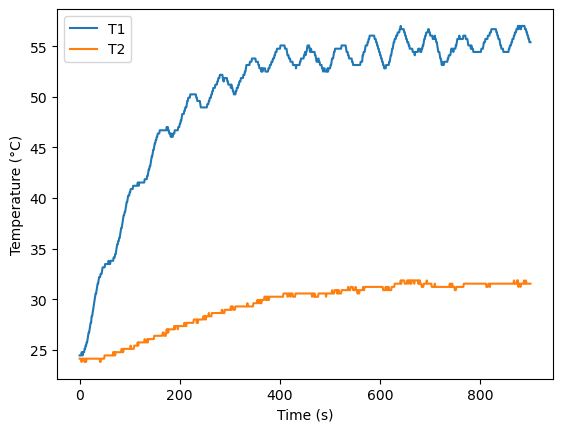

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

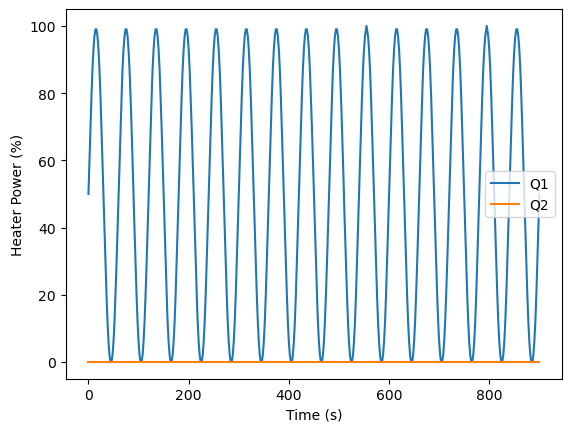

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

In [5]:
tc_data = TCLabExperiment(name="Sine Wave Test for Heater 1",
                            time=df['Time'].values,
                            T1=df['T1'].values,
                            u1=df['Q1'].values,
                            P1=200,
                            TS1_data=None,
                            d1 = None,
                            T2=df['T2'].values,
                            u2=df['Q2'].values,
                            P2=200,
                            TS2_data=None,
                            d2 = None,
                            Tamb=df['T1'].values[0])

## Calculate FIM at initial point (sine test)

In [6]:
# Load Pyomo.DoE functions
from pyomo.contrib.doe import (
    ModelOptionLib,
    DesignOfExperiments,
    MeasurementVariables,
    DesignVariables,
)

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {'Ua': 0.05147278733764012, 'Ub': 0.0005342082856927798, 'inv_CpH': 0.14622879403418604, 'inv_CpS': 99.99999754623846}

In [7]:
# Get time points for control decisions
t_control = tc_data.time

measurements = MeasurementVariables()
measurements.add_variables('Ts1', 
                              indices={0: t_control},
                              time_index_position = 0)

In [8]:
decisions = DesignVariables()

decisions.add_variables('U1',
                        indices={0: t_control},
                        time_index_position = 0,
                        lower_bounds=0,
                        upper_bounds=100,
                        values=tc_data.u1)

In [9]:
def create_model_doe(mod=None, model_option="stage2", theta=theta_values):
    return create_model(m=mod, model_option=model_option, data=tc_data, mode='doe', theta=theta, integrate_to_initialize=True, number_of_states=number_tclab_states)

In [10]:
# Create doe_object using DesignOfExperiments
doe_object1 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=SolverFactory('ipopt')
)

result = doe_object1.compute_FIM(
    mode='sequential_finite',
    formula = 'central'
)
result.result_analysis()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [11]:
results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.698903678286152
D-optimality: 7.837752571097882
E-optimality: -15.673734558200351
Modified E-optimality: 25.356611592208946

FIM:
 [[ 1.88459415e+08 -1.91393890e+08 -8.24201918e+06 -1.04121590e+03]
 [-1.91393890e+08  4.80931030e+09  6.51658566e+07  2.58102008e+04]
 [-8.24201918e+06  6.51658566e+07  1.46673544e+06  3.51179540e+02]
 [-1.04121590e+03  2.58102008e+04  3.51179540e+02  1.38519624e-01]]

eigenvalues:
 [4.81811358e+09 1.80716021e+08 4.06846518e+05 2.11965628e-16]

eigenvectors:
 [[ 4.13259139e-02 -9.98655750e-01  3.12867703e-02 -1.00557444e-13]
 [-9.99053330e-01 -4.17276557e-02 -1.22982147e-02 -5.33299017e-06]
 [-1.35872064e-02  3.07489171e-02  9.99434786e-01 -2.48897567e-06]
 [-5.36175981e-06 -1.45999972e-07  2.42198261e-06  1.00000000e+00]]


## Optimize next experiment (D-optimality)

In [12]:
# Extract the prior FIM and Jacobian information from the previous
# result to use for initialization.
prior = result.FIM.copy()
jac_for_initialization = result.jaco_information.copy()

# Set Ipopt options
solver = SolverFactory('ipopt')
solver.options['bound_push'] = 1E-10
solver.options['halt_on_ampl_error'] = 'yes'
solver.options['tol'] = 1E-5
solver.options['acceptable_tol'] = 1E-4
solver.options['max_iter'] = 500
#solver.options['linear_solver'] = 'ma57'

# Create a new DoE object
doe_object2 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=solver,
    prior_FIM=prior  # use previous experiment as prior
)

# Solve the DoE problem
square_result2, optimize_result2 = doe_object2.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=True,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="det",  # objective option (need to debug/improve initialization)
    jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
    step = 0.01  # step size
)


Ipopt 3.13.2: bound_push=1e-10
halt_on_ampl_error=yes
tol=1e-05
acceptable_tol=0.0001
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a co

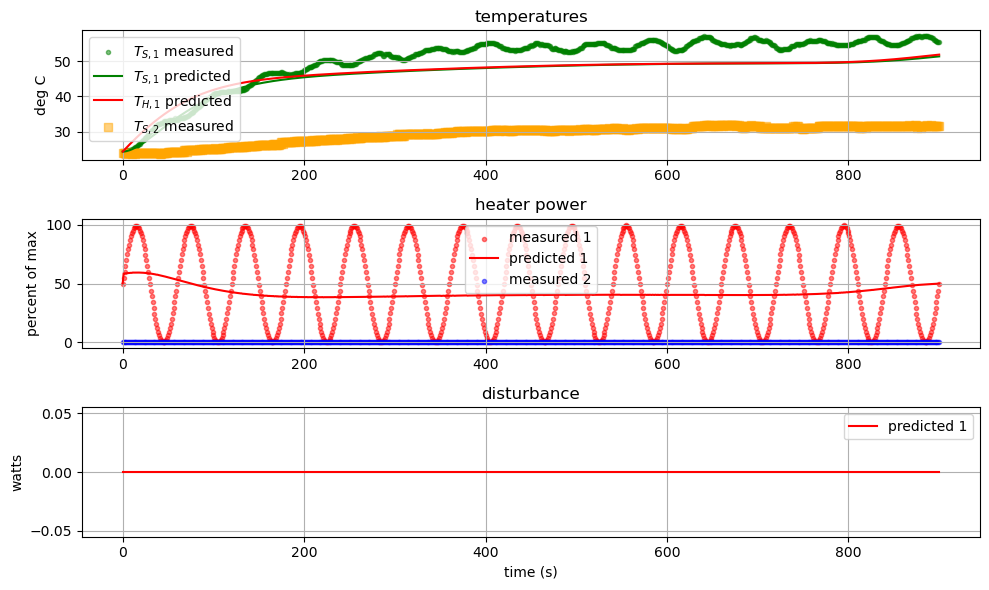

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [13]:
dopt_pyomo_doe_results = extract_plot_results(tc_data, optimize_result2.model)

In [14]:
optimize_result2.result_analysis()
results_summary(optimize_result2)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.69893583369588
D-optimality: 26.531030918910982
E-optimality: 2.9594744835364275
Modified E-optimality: 6.723402729535393

FIM:
 [[ 1.88804715e+08 -1.91397706e+08 -8.28467458e+06 -4.92310999e+03]
 [-1.91397706e+08  4.80931123e+09  6.51695303e+07  2.67464054e+04]
 [-8.28467458e+06  6.51695303e+07  1.48972300e+06  4.05780198e+03]
 [-4.92310999e+03  2.67464054e+04  4.05780198e+03  9.41058872e+02]]

eigenvalues:
 [4.81811557e+09 1.81062714e+08 4.27415429e+05 9.10907931e+02]

eigenvectors:
 [[-4.13299220e-02  9.98649980e-01 -3.14642159e-02 -2.41635003e-04]
 [ 9.99053148e-01  4.17338944e-02  1.22914378e-02  9.82538250e-05]
 [ 1.35883981e-02 -3.09273229e-02 -9.99394209e-01 -8.37089027e-03]
 [ 5.59963665e-06 -2.16817107e-05 -8.37492350e-03  9.99964929e-01]]


## Optimize next experiment (A-optimality)

In [15]:
# Create a new DoE object
doe_object3 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=solver,
    prior_FIM=prior  # use previous experiment as prior
)

# Solve the DoE problem
square_result3, optimize_result3 = doe_object3.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=False,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="trace",  # objective option (need to debug/improve initialization)
    jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
    step = 0.01  # step size
)

Ipopt 3.13.2: bound_push=1e-10
halt_on_ampl_error=yes
tol=1e-05
acceptable_tol=0.0001
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a co

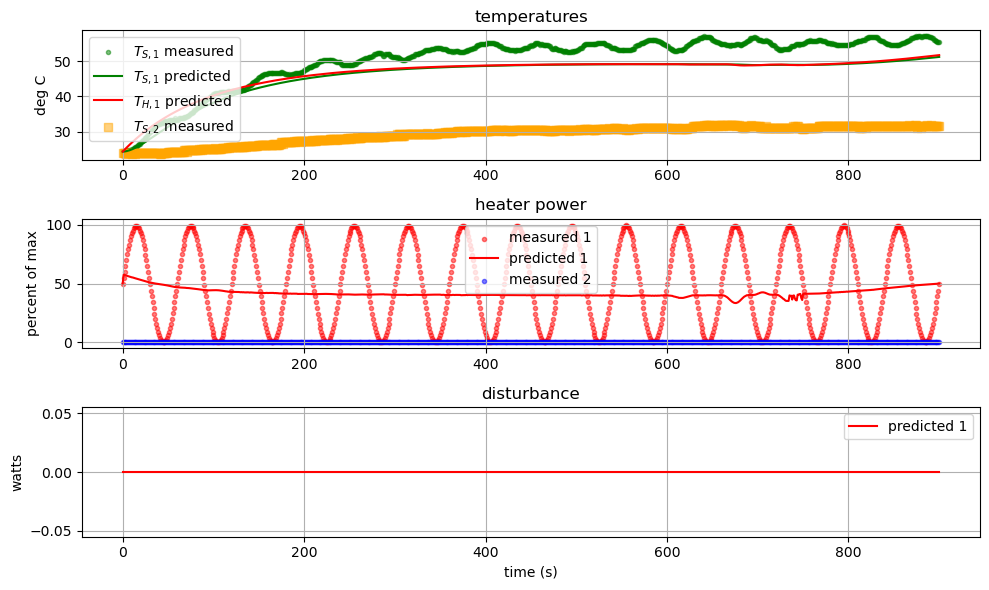

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [16]:
aopt_pyomo_doe_results = extract_plot_results(tc_data, optimize_result3.model)

In [17]:
optimize_result3.result_analysis()
results_summary(optimize_result3)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.698935615611008
D-optimality: 26.48526831420907
E-optimality: 2.914037310591542
Modified E-optimality: 6.7688398930563

FIM:
 [[ 1.88802755e+08 -1.91397651e+08 -8.28386649e+06 -4.86647505e+03]
 [-1.91397651e+08  4.80931114e+09  6.51694039e+07  2.66539504e+04]
 [-8.28386649e+06  6.51694039e+07  1.48935725e+06  3.93094099e+03]
 [-4.86647505e+03  2.66539504e+04  3.93094099e+03  8.48545402e+02]]

eigenvalues:
 [4.81811547e+09 1.81060714e+08 4.27099999e+05 8.20422024e+02]

eigenvectors:
 [[-4.13298911e-02  9.98650112e-01 -3.14601358e-02 -2.32910505e-04]
 [ 9.99053150e-01  4.17338115e-02  1.22916056e-02  9.47445364e-05]
 [ 1.35883641e-02 -3.09231759e-02 -9.99396692e-01 -8.08489026e-03]
 [ 5.57962216e-06 -2.13691315e-05 -8.08876916e-03  9.99967285e-01]]
